In [1]:
from collections import Counter
import itertools
import logging
import os

import einops
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import torch
import torch.nn.functional as F
from unseal.hooks import Hook, HookedModel
from tqdm import tqdm
from unseal.hooks.common_hooks import save_output

from circuits_util import get_o_weight, get_qkv_weights
from datasets import get_dataset
from model import GrokkingTransformer
from utils import load_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cpu':
    logging.warning('No GPU found! Using CPU')

In [2]:
model_name = 'Tied Embeddings'
ckpt, ckpt_dir = load_model(model_name)

# model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
model.eval()

GrokkingTransformer(
  (embedding): Embedding(98, 128)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer): Sequential(
    (0): EncoderBlock(
      (self_attn): MultiheadAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=False)
        (o_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (linear_net): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): Dropout(p=0, inplace=False)
        (2): ReLU()
        (3): Linear(in_features=512, out_features=128, bias=True)
      )
      (norm1): Identity()
      (norm2): Identity()
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (output): TransposedLinear(
    (model): Embedding(98, 128)
  )
  (loss): CrossEntropyLoss()
)

In [3]:
def mlp_key_attribution(model, inputs, targets, target='logit') -> torch.Tensor:
    if target not in ['logit', 'logprob']:
        raise ValueError
    
    # computes attribution score for the mlp activations for a given model for all datapoints in inputs
    unembed = model.output.weight
    value_layer = model.transformer[0].linear_net[-1].weight
    hooked_model = HookedModel(model)
    save_key_mag_hook = Hook("transformer->0->linear_net->2", save_output(), key="save_key_magnitude")  # hook the key layer
    hooked_model(inputs, hooks=[save_key_mag_hook])
    
    # get activation for last token
    activations = hooked_model.save_ctx['save_key_magnitude']['output'][...,-1,:].to(unembed.device)
    # compute attribution
    attribution = (value_layer[:,None] * activations[None,:])
    unembed = unembed[targets]
    attribution = torch.einsum('ijk,ji->jk', attribution, unembed)
    if target == 'logprob':
        attribution = attribution * (1 - torch.nn.functional.softmax(attribution, dim=-1))
    
    return attribution
    

In [4]:
def pre_relu_head_position_contribution(model, inputs, targets):
    hooked_model = HookedModel(model)
    key_layer = model.transformer[0].linear_net[0].weight
    value_layer = model.transformer[0].linear_net[-1].weight
    out_proj = torch.stack(model.transformer[0].self_attn.o_proj.weight.chunk(4, dim=1), dim=1)
    context_len = inputs.shape[1]
    mask = model.self_attn_mask[:context_len,:context_len]
    
    # apply embedding and pos encoding
    inputs = model.pos_encoding(model.embedding(inputs))
    qkv = model.transformer[0].self_attn.qkv_proj(inputs)
    # Separate Q, K, V from linear output
    qkv = einops.rearrange(qkv, 'batch seq_length (num_heads head_dim) -> batch num_heads seq_length head_dim', head_dim=3*model.transformer[0].self_attn.head_dim)
    q, k, v = qkv.chunk(3, dim=-1)
    
    # Determine value outputs
    values, attention = model.transformer[0].self_attn._attn(q, k, v, mask=mask)
    attn_out = torch.einsum('bijk,bilj->biljk', values, attention)[:,:,-1] # only look at effect on last token
    out = torch.einsum('bijk,dik->bijd', attn_out, out_proj) # (batch head emb_dim)
    out = torch.einsum('bijk,lk->bijl', out, key_layer) # (batch head num_neurons)
    # TODO: residual contribution
    
    return out

    

In [5]:
# What's the distribution over key magnitudes for these three value vectors, over the whole dataset?
# Which inputs activate them the most?
dataset = torch.from_numpy(get_dataset(descr='minus', num_elements=97, data_dir='./data', no_op_token=True).data).to(device)

In [6]:
target = 'logprob'
attributions = mlp_key_attribution(model, dataset[:,:-1], dataset[:,-1], target=target).detach().cpu().numpy()
head_position_contributions = pre_relu_head_position_contribution(model, dataset[:,:-1], dataset[:,-1]).detach().cpu().numpy()

In [7]:
os.makedirs(f"{model_name}/head_pos_attributions/{target}", exist_ok=True)
for j in tqdm(range(512)):
    vmin = np.min(head_position_contributions[:,:,:,j])
    vmax = np.max(head_position_contributions[:,:,:,j])

    fig, axes = plt.subplots(4,4,figsize=(20,20))
    for i in range(12):
        row = i//4
        col = i%4
        head_attr = axes[row,col].imshow(head_position_contributions[:,col,row,j].reshape(97,97), origin='lower', vmin=vmin, vmax=vmax)
        if row == 0:
            axes[row,col].set_title(f'Head {col}, Pos {row}')
        else:
            axes[row,col].set_title(f'Pos {row}')
        if row != 3:
            # set xaxis off
            axes[row,col].set_xticks([])        
        if col != 0:
            axes[row,col].set_yticks([])
    
    fig.colorbar(head_attr, ax=axes[:3,:])
    
    axes[3,0].imshow(attributions[:,j].reshape(97,97), origin='lower')
    axes[3,0].set_title(f'Attribution {j}')
    attr = axes[3,1].imshow(attributions[:,j].reshape(97,97), origin='lower')
    axes[3,1].set_title(f'Attribution {j}')
    for col in range(1,4):
        axes[3,col].set_yticks([])
    fig.colorbar(attr, ax=axes[3,:2])
    axes[3,2].axis('off')
    axes[3,3].axis('off')
    plt.savefig(f"{model_name}/head_pos_attributions/{target}/{j}.png", facecolor='white')
    plt.close()

100%|█████████████████████████████████████████| 512/512 [05:36<00:00,  1.52it/s]


In [ ]:
# os.makedirs(f'{model_name}/final_attributions', exist_ok=True)
# for i in range(512):
#     plt.imshow(attributions[:,i].detach().cpu().numpy().reshape(97,97), origin='lower')
#     plt.colorbar()
#     plt.savefig(f'{model_name}/final_attributions/{i}.png')
#     plt.close()

49 - 41, [149 141 492  12 198  28 348   2 501 151]


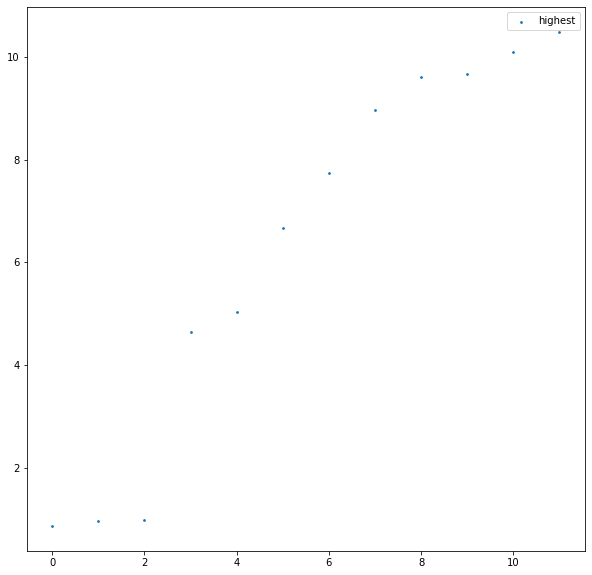

41 - 49, [106 220 348  28 198  12   2 501 141 151]


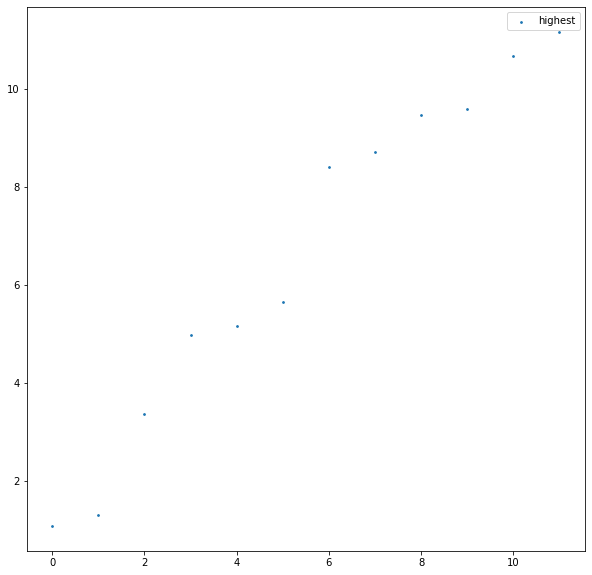

37 - 29, [149 141 492  12 198  28   2 348 501 151]


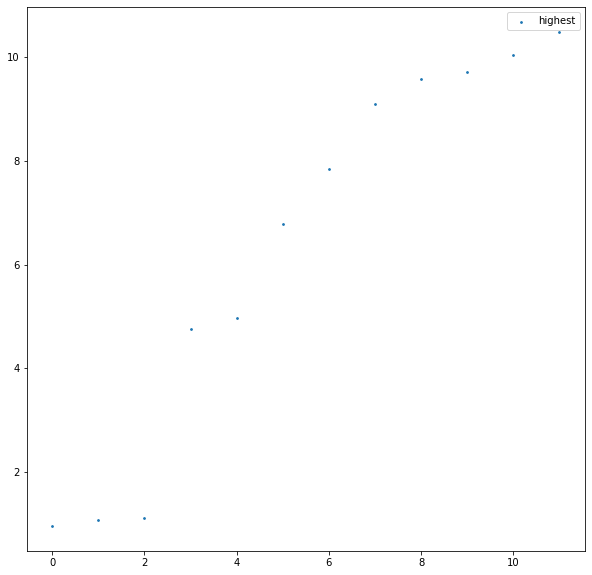

25 - 41, [445 353 166 451   0 437 490 361  17 294]


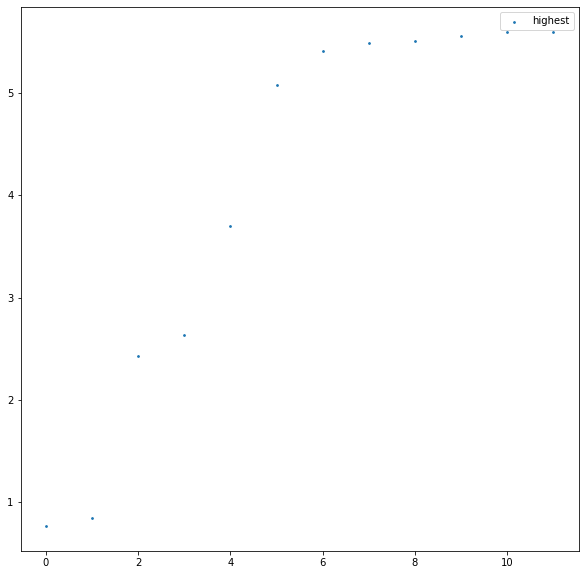

29 - 37, [106 220 348  28 198  12   2 501 141 151]


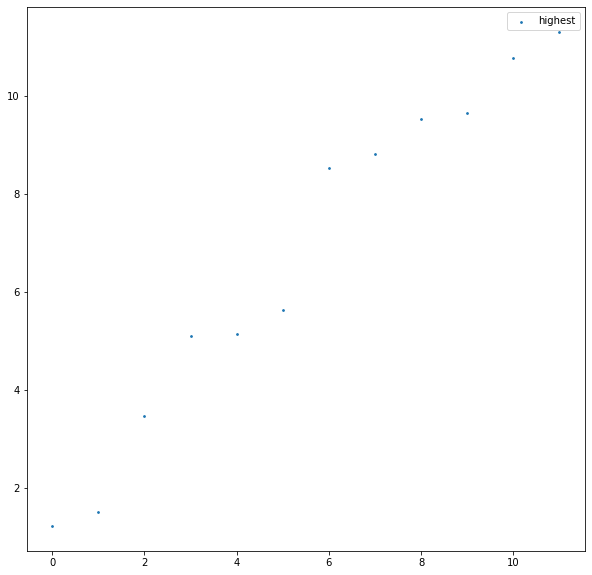

1 - 17, [445 353 166 451 437 490   0  17 361 294]


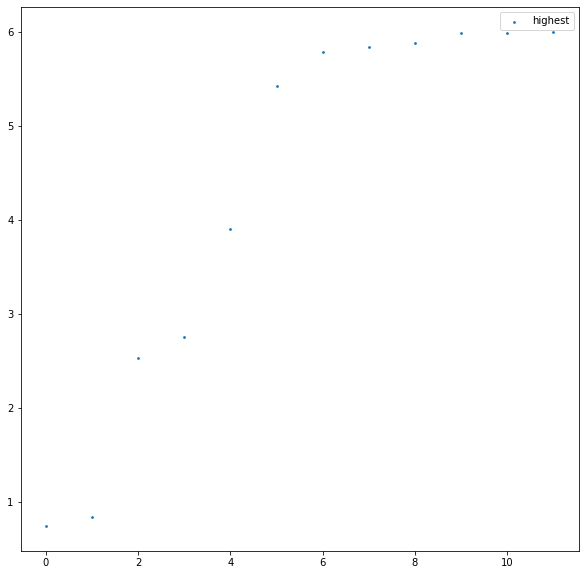

35 - 43, [106 220 151 348  28 141 198 501   2  12]


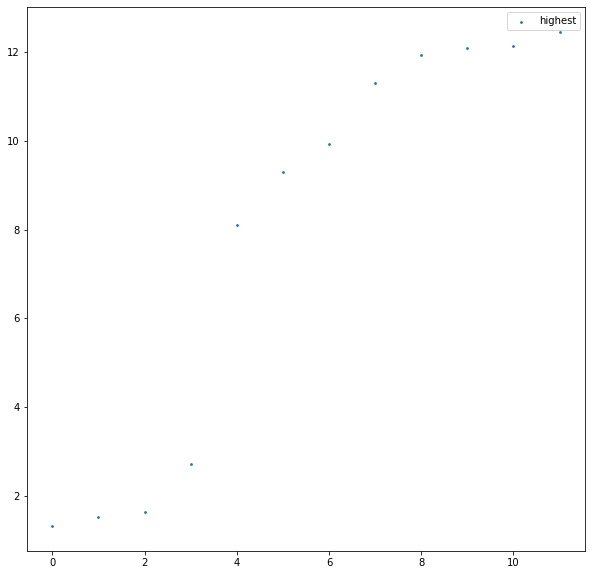

86 - 5, [445 353 166 451 437 490   0  17 361 294]


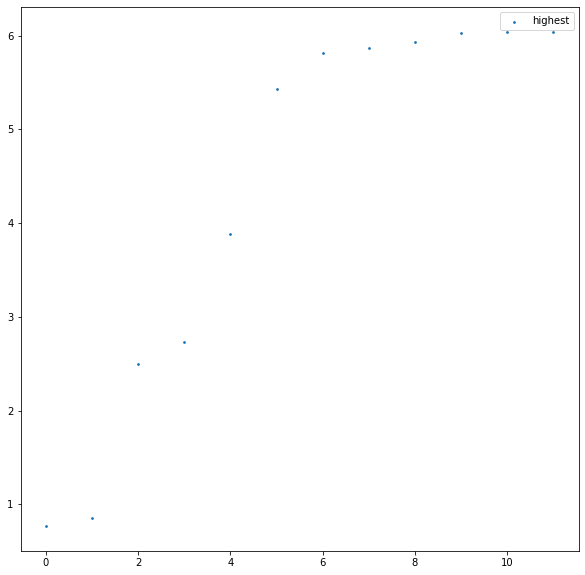

35 - 13, [198  45 151 492 501   2 111 226 348  28]


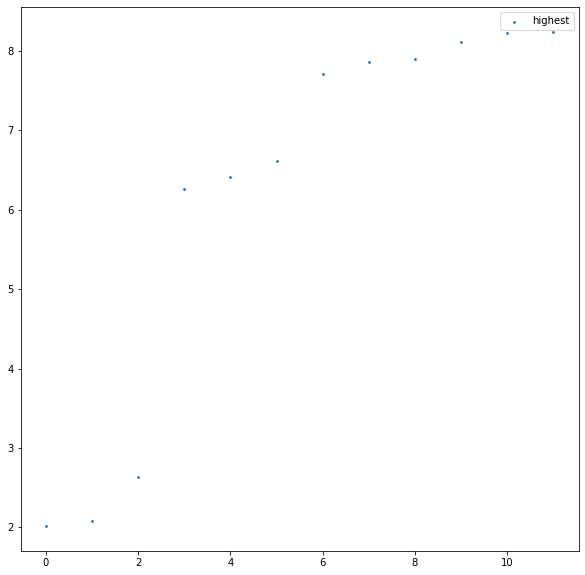

In [8]:
# idx = 97*70 + 10
# print(dataset[idx])


if isinstance(attributions, torch.Tensor):
    attributions = attributions.detach().cpu().numpy()
summed = np.clip(attributions, 0, None).sum(axis=1)
top_ten_sum = np.sort(attributions)[:,-10:].sum(axis=1)

share_top_ten = top_ten_sum / summed
argsorted_share = np.argsort(share_top_ten)

highest = np.sort(attributions[argsorted_share[-10:]])
highest_neurons = np.argsort(attributions[argsorted_share[-10:]], axis=1)
# lowest = np.sort(attributions[argsorted_share[0]])
for i in range(1,10):
    print(f"{argsorted_share[-i]//97} - {argsorted_share[-i]%97}, {highest_neurons[-i,-10:]}")
# plt.imshow(attributions[:,428].reshape(97,97), origin='lower')

# highest_neurons = highest_neurons[::-1][:14]
# plt.figure()
# data = attributions[:,highest_neurons].mean(axis=1).reshape(97,97)
# plt.imshow(data, origin='lower')
# plt.colorbar()
# plt.show()
# for i in highest_neurons:
#     plt.figure()
#     plt.imshow(attributions[:,i].reshape(97,97), origin='lower')
#     plt.title(f"{i}")
    
    k = 12
    plt.figure(figsize=(10,10))
    plt.scatter(np.arange(k), highest[-i,-k:], label='highest', s=3)
    # plt.plot(np.arange(512), lowest, label='lowest', c='orange')
    plt.legend()
    plt.show()

In [181]:
x = argsorted_share[-1]//97
y = argsorted_share[-1]%97
save_dir = f'{model_name}/time_evolution_{x}_{y}'
paths = [ckpt_dir + f"/epoch={epoch}-step={epoch*10+9}.ckpt" for epoch in range(0, 2000, 5) if os.path.exists(ckpt_dir + f"/epoch={epoch}-step={epoch*10+9}.ckpt")]
epochs = [int(path.split('/')[-1].split('-')[0].split('=')[-1]) for path in paths]
os.makedirs(save_dir, exist_ok=True)
for ckpt, epoch in tqdm(zip(paths, epochs)):
    # model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
    model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
    model.eval()
    attributions = mlp_key_attribution(model, dataset[:,:-1], dataset[:,-1], target=target).detach().cpu().numpy()[:, highest_neurons]
    
    fig, axes = plt.subplots(4, 3, sharex=True, figsize=(10,10), gridspec_kw={'wspace':0})
    for row, col in itertools.product(range(4), range(3)):
        if row == 3 and col == 2:
            continue
        plot = axes[row,col].imshow(attributions[:,row*3+col].reshape(97,97), origin='lower', vmin=np.min(attributions), vmax=np.max(attributions))
        axes[row,col].set_title(str(highest_neurons[row*3+col]))
        axes[row,col].set_xticks([])
        axes[row,col].set_yticks([])
    fig.colorbar(plot, ax=axes)
    axes[-1,-1].axis('off')
    
    plt.suptitle(f'Epoch {epoch}')
    plt.savefig(f"{model_name}/time_evolution_{x}_{y}/{epoch}.png", facecolor='white')
    plt.close()
    
    

157it [06:20,  2.77s/it]

220it [00:03, 59.58it/s]


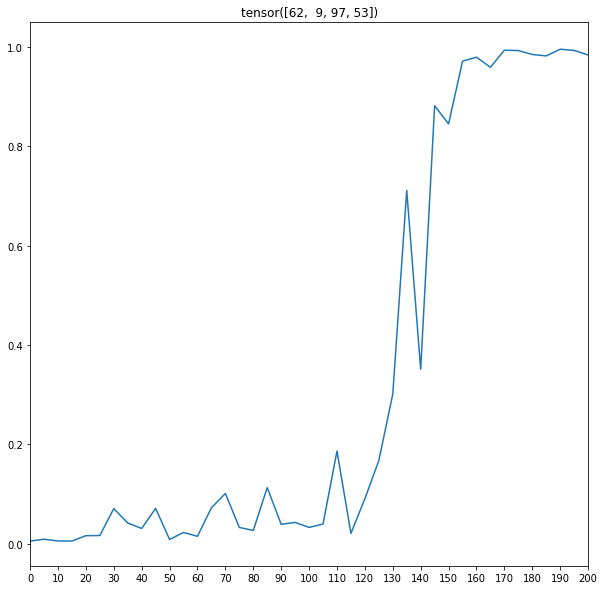

In [ ]:
# what's the probability of the correct output on this sample over time?
for idx in argsorted_share[-1:]:
    probs = []
# idx = argsorted_share[0]
    for ckpt, epoch in tqdm(zip(paths, epochs)):
        # model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
        model = GrokkingTransformer.load_from_checkpoint(ckpt).to(device)
        model.eval()
        probs.append(model(dataset[idx,None,:-1])[0,-1].softmax(dim=0)[dataset[idx,-1]].item())
    plt.figure(figsize=(10,10))
    plt.xticks(np.arange(0,epochs[-1],10))
    plt.xlim(0,200)
    plt.title(f"{dataset[idx]}")
    plt.plot(epochs, probs)


In [10]:
neurons = [444, 4]

In [11]:
# value_logits = {key: model.output(values[key]) for key in values.keys()}
value_logits = {key: model.output(model.transformer[0].linear_net[-1].weight[:,key]) for key in neurons}
# subtract mean to center logits
value_logits = {key: value_logits[key] - torch.mean(value_logits[key]) for key in value_logits.keys()}

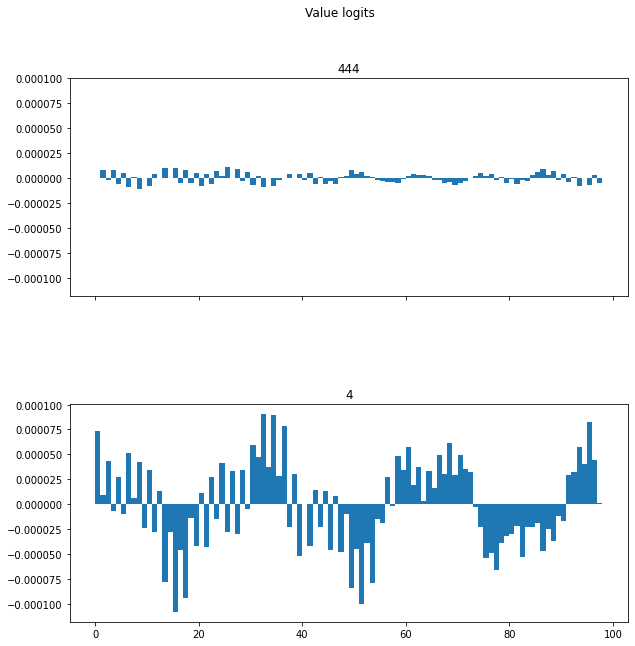

In [12]:
fig, ax = plt.subplots(len(neurons),1,sharex=True, sharey=True, gridspec_kw={'hspace': 0.5}, figsize=(10,10))
for i, key in enumerate(neurons):
    ax[i].bar(np.arange(len(value_logits[key])), value_logits[key].detach().cpu().numpy(), width=1, align='edge')
    ax[i].set_title(f"{key}")
plt.suptitle('Value logits')
plt.savefig(os.path.join(model_name, 'value_logits.png'), facecolor='white')
plt.show()

## Composition of neuron 53 with the different attention heads

$W_O^h W_K[53,:]$ for different $h$

In [13]:
W_O = torch.stack(torch.chunk(model.transformer[0].self_attn.o_proj.weight, 4, 1), 1)
print(f'{W_O.shape = }')
W_V = einops.rearrange(get_qkv_weights(model.transformer[0].self_attn)[-1], 'heads head_dim emb_dim -> head_dim  heads emb_dim')
print(f'{W_V.shape = }')
W_K = model.transformer[0].linear_net[0].weight
print(f'{W_K.shape = }')

W_O.shape = torch.Size([128, 4, 32])
W_V.shape = torch.Size([32, 4, 128])
W_K.shape = torch.Size([512, 128])


In [14]:
KO_comp = torch.einsum('ij,jkl->ikl', W_K, W_O)
KOV_comp = torch.einsum('ij,jkl,lkn->ikn', W_K, W_O, W_V)
x = model.pos_encoding(model.embedding(dataset.data[:,:2]))
KOVx_comp = torch.einsum('ij,jkl,lkn,btn->ikbt', W_K, W_O, W_V, x)
print(KOVx_comp.shape)
KOVx_comp = einops.rearrange(KOVx_comp, 'neurons heads (h w) t -> neurons heads h w t', h=97)
print(f'{KO_comp.shape = }')
print(f'{KOV_comp.shape = }')
print(f'{KOVx_comp.shape = }')

torch.Size([512, 4, 9409, 2])
KO_comp.shape = torch.Size([512, 4, 32])
KOV_comp.shape = torch.Size([512, 4, 128])
KOVx_comp.shape = torch.Size([512, 4, 97, 97, 2])


In [15]:
neuron = 444
neuron_KO_comp = KO_comp[neuron]
neuron_KOV_comp = KOV_comp[neuron]
neuron_KOVx_comp = KOVx_comp[neuron]


In [16]:
print(f'Neuron {neuron}')
print(f'Head  KO  KOV')
for i in range(4):
    print(f'{i} {torch.norm(neuron_KO_comp[i]).item():.3f} {torch.norm(neuron_KOV_comp[i]).item():.3f}')

Neuron 444
Head  KO  KOV
0 0.000 0.000
1 0.000 0.000
2 0.000 0.000
3 0.000 0.000


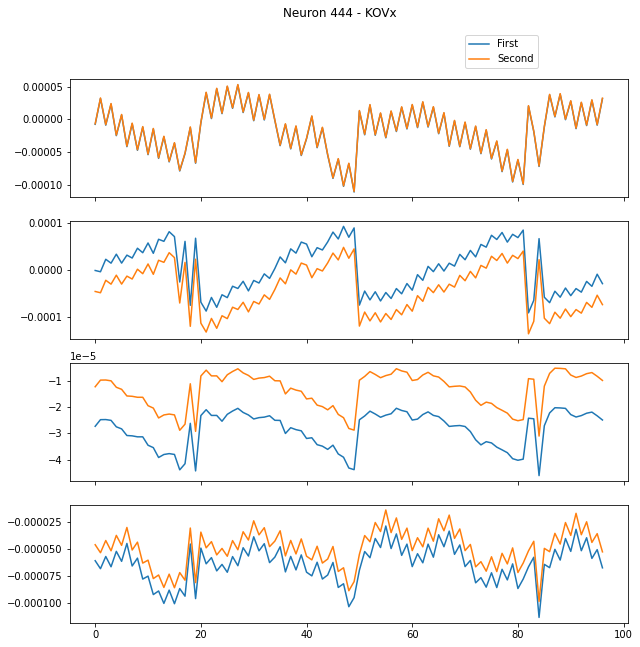

In [17]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,10))
for row in range(4):
    plot = axes[row].plot(np.arange(97), neuron_KOVx_comp[row,torch.arange(97),torch.arange(97)].detach().cpu().numpy(), label=['First', 'Second'])

axes[0].legend(bbox_to_anchor=(0.7, 1.05))
plt.suptitle(f"Neuron {neuron} - KOVx")
plt.show()

### Find largest KOV composition 

In [18]:
KOV_norms = torch.norm(KOV_comp, dim=-1)
# norm by sum over heads
KOV_norms /= torch.sum(KOV_norms, dim=-1, keepdim=True)
# find indices with largest norms
sorted_by_neuron = KOV_norms.argsort(dim=0, descending=True)
print(sorted_by_neuron)
print(KOV_norms[364,0])
print(KOV_norms[274,1])
print(KOV_norms[393,2])
print(KOV_norms[444,3])

tensor([[458,  90, 119,  15],
        [464, 290,  63, 171],
        [339, 254, 448, 306],
        ...,
        [279, 220,  25, 114],
        [386, 141, 388, 447],
        [ 15, 106,  42, 475]], device='cuda:0')
tensor(0.3039, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0666, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.2466, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.1508, device='cuda:0', grad_fn=<SelectBackward0>)


In [19]:
pre_relu_hook = Hook('transformer->0->linear_net->0', save_output(), 'pre_relu')
hooked_model = HookedModel(model)
_ = hooked_model(dataset[:,:-1], hooks=[pre_relu_hook])

In [20]:
pre_relu = hooked_model.save_ctx['pre_relu']['output'][:,-1]
print(pre_relu.shape)

torch.Size([9409, 512])


In [21]:
head4_neurons = [0,4,29,64,69,109,133,140,160,162,164,184,191,204,212,223,224,229,282,283,293,313,314,347,349,369,376,390,431,444,458,459]
# head4_neurons = [4,444]
pre_relu_neuron = pre_relu[:,head4_neurons].reshape((97,97,len(head4_neurons))).detach().cpu().numpy()


Text(0.5, 1.0, 'Neuron 4 or 444 active')

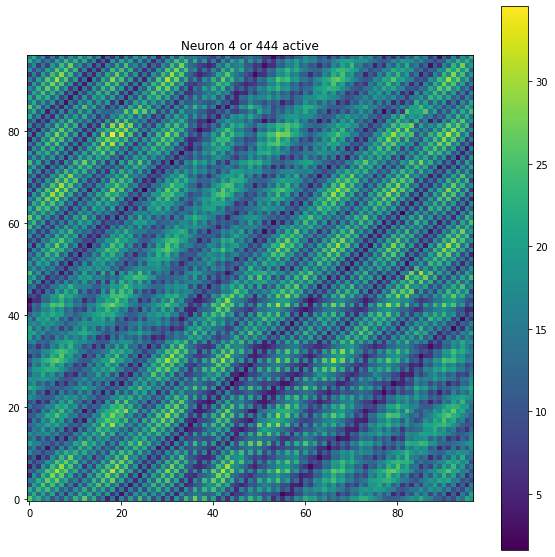

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(np.sum(np.array([np.clip(pre_relu_neuron[...,i],0,None) for i in range(len(head4_neurons))]),axis=0), origin='lower')
plt.colorbar()
plt.title('Neuron 4 or 444 active')

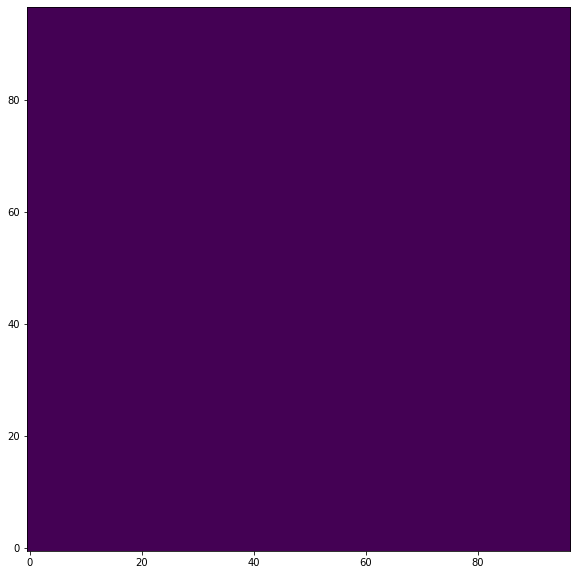

In [23]:
# print(attributions.shape)
plt.figure(figsize=(10,10))
plt.imshow((attributions[:,444] + attributions[:,4]).reshape(97,97), origin='lower')

## Look at 4-11 since it seems to trigger the head 4 neurons

In [24]:
idx = 97*4 + 10
sample = dataset[idx:idx+1]
sample_attr = attributions[idx]
neurons_desc = np.argsort(sample_attr)[::-1]
attr_desc = sample_attr[neurons_desc]
sample_head_contr = head_position_contributions[:,:,:2,neurons_desc]
print(sample_head_contr.shape)

(9409, 4, 2, 512)


In [25]:
k = 20
topk_attr = attr_desc[:k]
topk_neurons = neurons_desc[:k]
topk_head_contr = sample_head_contr[...,:k]


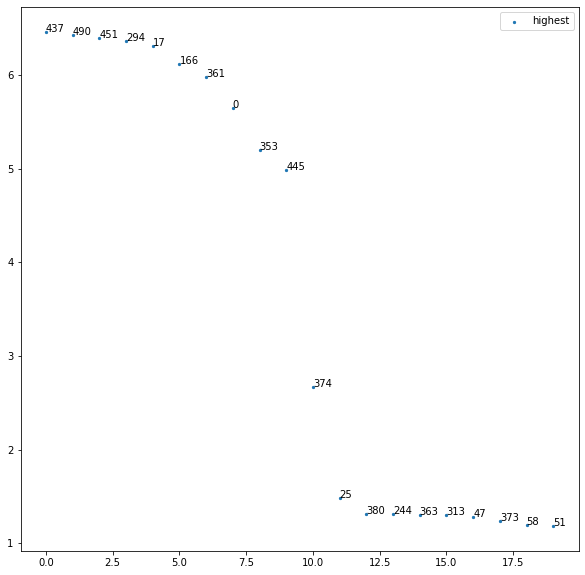

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(np.arange(k), topk_attr[:k], label='highest', s=5)
for i, n in enumerate(topk_neurons):
    plt.text(i, topk_attr[i], f'{n}')
plt.legend()
plt.show()

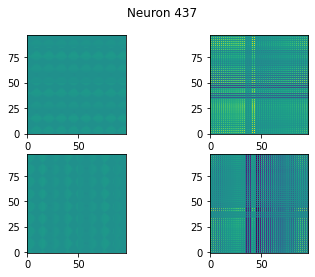

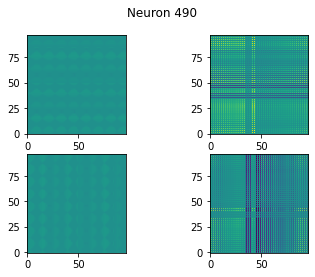

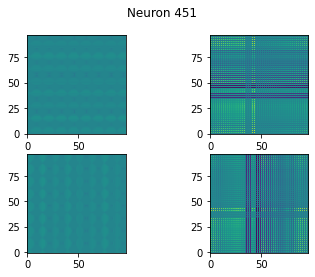

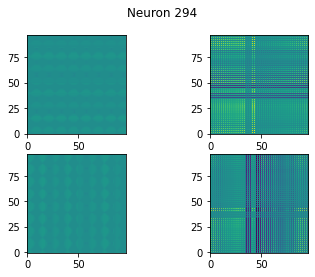

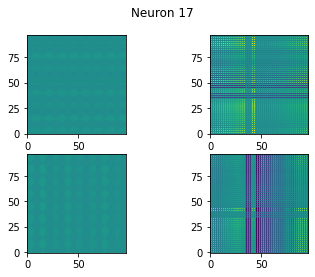

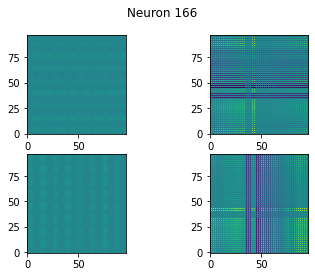

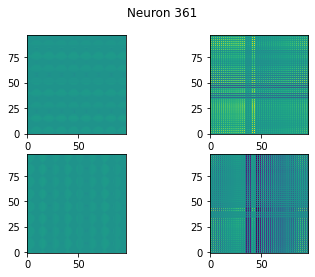

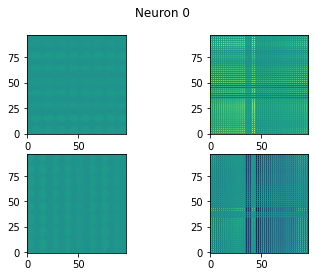

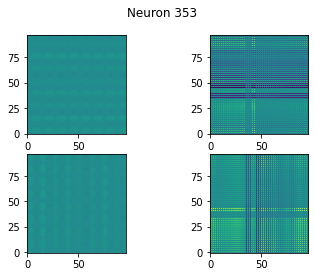

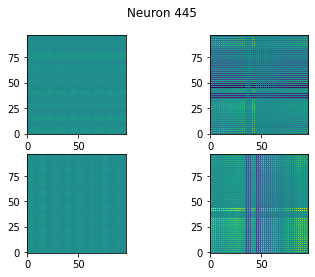

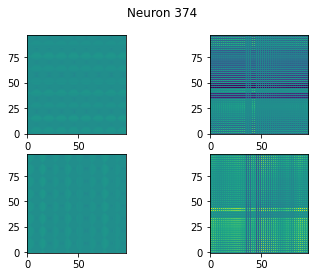

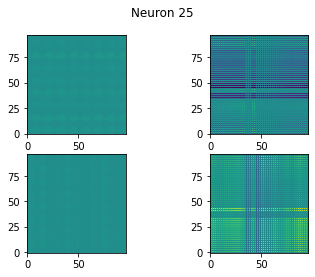

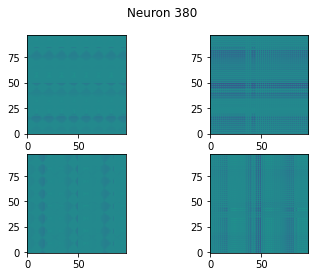

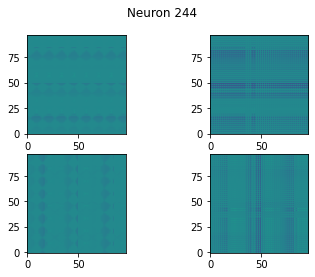

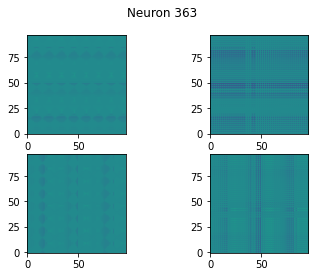

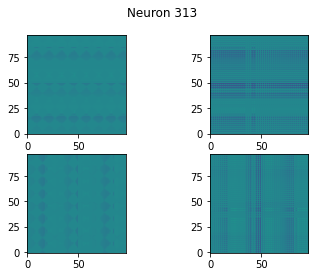

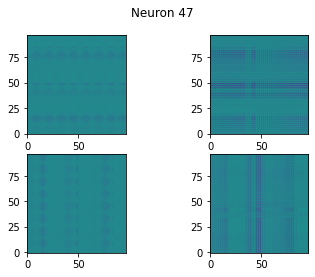

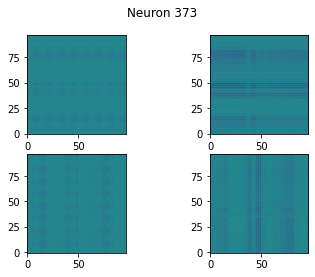

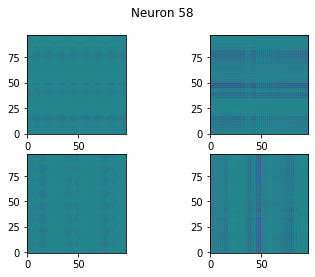

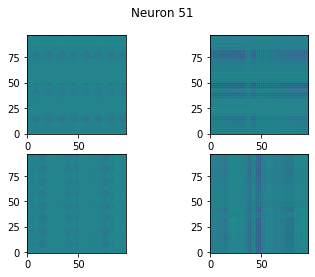

In [27]:
for i, n in enumerate(topk_neurons):
    fig, ax = plt.subplots(2,2)
    plt.suptitle(f"Neuron {n}")
    vmin = np.min(topk_head_contr[...,i])
    vmax = np.max(topk_head_contr[...,i])
    ax[0,0].imshow(topk_head_contr[:,2,0,i].reshape(97,97), origin='lower', vmin=vmin, vmax=vmax)
    ax[0,1].imshow(topk_head_contr[:,3,0,i].reshape(97,97), origin='lower', vmin=vmin, vmax=vmax)
    ax[1,0].imshow(topk_head_contr[:,2,1,i].reshape(97,97), origin='lower', vmin=vmin, vmax=vmax)
    ax[1,1].imshow(topk_head_contr[:,3,1,i].reshape(97,97), origin='lower', vmin=vmin, vmax=vmax)

In [28]:
pre_relu_hook = Hook('transformer->0->linear_net->0', save_output(), 'pre_relu')
hooked_model = HookedModel(model)
_ = hooked_model(sample[:,:-1], hooks=[pre_relu_hook])
pre_relu = hooked_model.save_ctx['pre_relu']['output'][0,-1].detach().cpu().numpy()
post_relu = np.clip(pre_relu, 0, None)

In [29]:
active_neurons = np.arange(512)[post_relu>0]
print(len(active_neurons))
head4_active = np.intersect1d(active_neurons, head4_neurons)
print(post_relu[head4_active].mean() - post_relu[active_neurons].mean())
print(post_relu[head4_active].mean())
print(post_relu[active_neurons].mean())
print(head4_active)

131
-0.2568164
3.3527703
3.6095867
[  0 160 224 313 349]


## Plotting value vectors cossim for same number but different position


In [30]:
q,k,v = get_qkv_weights(model.transformer[0].self_attn)
encoded_data = model.pos_encoding(model.embedding(dataset[:,:-1]))
values = torch.einsum('btd,hkd->bhtk', encoded_data, v)#[:,-1,:-1]
print(values.shape)

torch.Size([9409, 4, 3, 32])


## Plotting Value Vector Cossim for different numbers and same head

In [31]:
q,k,v = get_qkv_weights(model.transformer[0].self_attn)
encoded_data = model.pos_encoding(model.embedding(dataset[:,:-1]))
values = torch.einsum('btd,hkd->bhtk', encoded_data, v)[np.arange(0,9409,98)]
print(f'{values.shape = }')

values.shape = torch.Size([97, 4, 3, 32])


In [32]:
def cossim(ref_value, values):
    return (values @ ref_value) / (np.sqrt(np.sum(values**2, axis=-1)) * np.sqrt(np.sum(ref_value**2, axis=-1)))

### Position 1

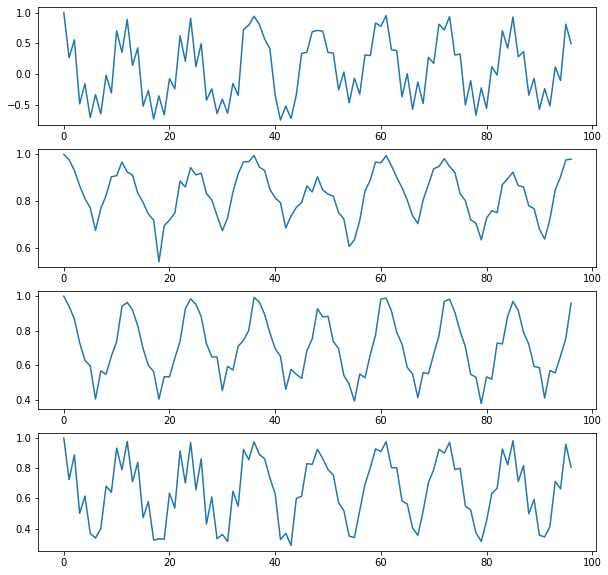

In [33]:
fig, axes = plt.subplots(4,1, figsize=(10,10))
ref_value = values[0,:,0]
for i in range(4):
    axes[i].plot(np.arange(97), cossim(ref_value[i].cpu().detach().numpy(), values[:,i,0].cpu().detach().numpy()))
plt.show()

### Position 2

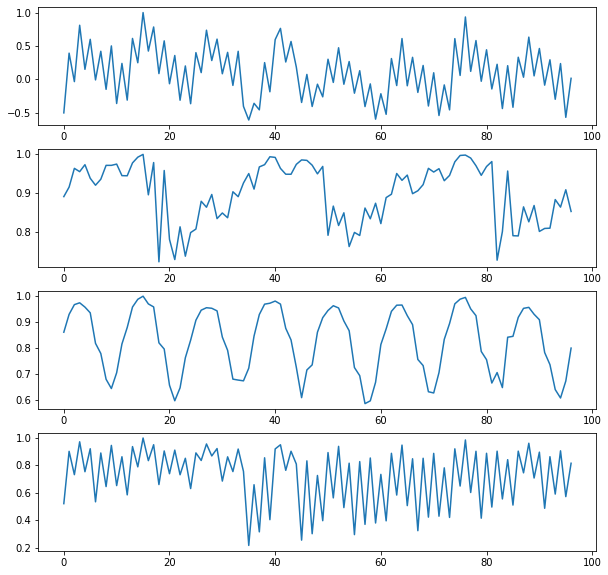

In [34]:
fig, axes = plt.subplots(4,1, figsize=(10,10))
ref_value = values[15,:,1]
for i in range(4):
    axes[i].plot(np.arange(97), cossim(ref_value[i].cpu().detach().numpy(), values[:,i,1].cpu().detach().numpy()))
plt.show()

### Embeddings themselves

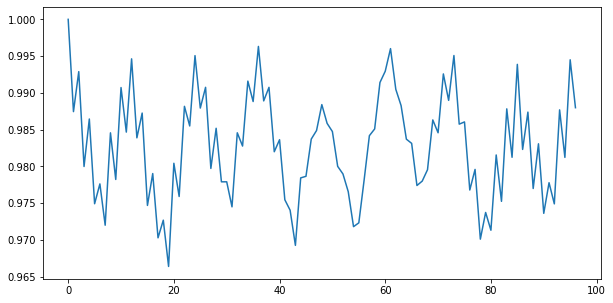

In [35]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
embeds = encoded_data[np.arange(0,9409,98)][:,0]
ref_value = embeds[0]
axes.plot(np.arange(97), cossim(ref_value.cpu().detach().numpy(), embeds.cpu().detach().numpy()))
plt.show()

### Plotting some modulo functions to test fit

In [36]:
def mod(x, k):
    return x - k * np.floor(x/k)


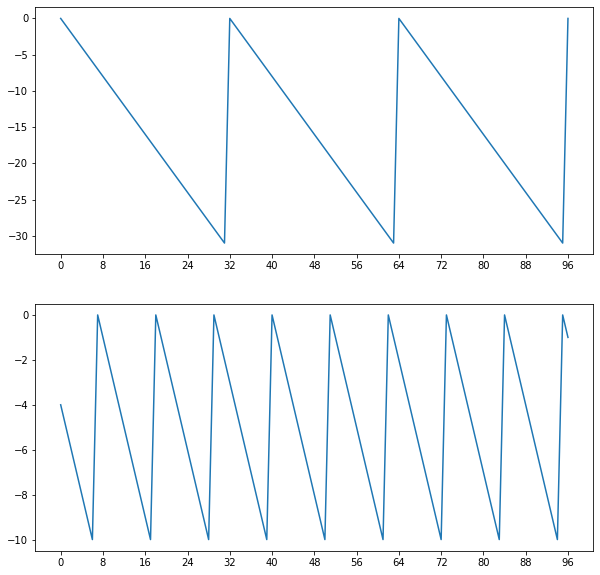

In [41]:
x = np.arange(97)
fig, axes = plt.subplots(2,1, figsize=(10,10))
moduli = [32,11]
offsets = [0, 4]
for i in range(2):
    axes[i].plot(x, -mod(x+offsets[i], moduli[i])+30)
    axes[i].xaxis.set_ticks(np.arange(0,97,8))
plt.show()